# Fraud detection

This notebook presents the short analyses and transformation of the fraud dataset available at the following [hyperlink](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The notebook also covers data transformations and training the dependent variable (fruad indicator) via the following technique:

**Data analyses**

- High-level data overview
- Checking missings of data
- Checking the distribution of the variables (histogram & boxplots)
- Analyses the correlations between variables

**Data transformations**

- [Outliers detection](#Outliers-detection) (Isolation Forest)
- [Standarisation of the data](#Standarisation)
- [Dimensionality reduction](#PCA)

[**Modelling fraud**](#Modelling-part)
- Decision Tree
- K nearest neighbors
- Logistic regression
- Support-vector machine
- Gaussian Naive Bayes
- Linear discriminant analysis
- multi-layer perceptron (neural network)


## Import the data

Firstly, let's load the necessary dataset and make a high-level overview of the data:

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv('C:/Users/garri/Desktop/Moje/Python stuff/fraud_detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, the given variables are not interpretable. We do not have enough information in order to fully understand the data. However, from technical point of view this is not the impediment.

### Extracting test dataset

Once we have the data loaded, let's split it into train/test sample. Conceptually, the testset should reflect the dataset that we will see in our databse in the future. Hence, no single decisions should be made on testset-based results. Consequently, we forget about testset until the final model model is selected.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(df)

In [5]:
print(df_train.Class.value_counts())
print(df_test.Class.value_counts())

0    213216
1       389
Name: Class, dtype: int64
0    71099
1      103
Name: Class, dtype: int64


## Analyses of the dataset

Before any analyses, let's take a look at the data from high-level perpective.

In [6]:
from matplotlib import pyplot as plt
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


One can see that most of the features are centered, nevertheless the standard deviation is not consistent across the variables. Later on we can apply a standarisation of the data. 

### Missing data

In [7]:
df.isnull().sum(axis = 0).sum(axis = 0)

0

Fortunetaly, there are no missing data in our dataset. If that's not the case, one should check the type of missings (completely at random, at random, not at random) and, if neccessary, choose the imputation technique (mean, median, random sampling, etc.)

### Distribution analyses

Before going further, let's take a look at the distribution of variables:

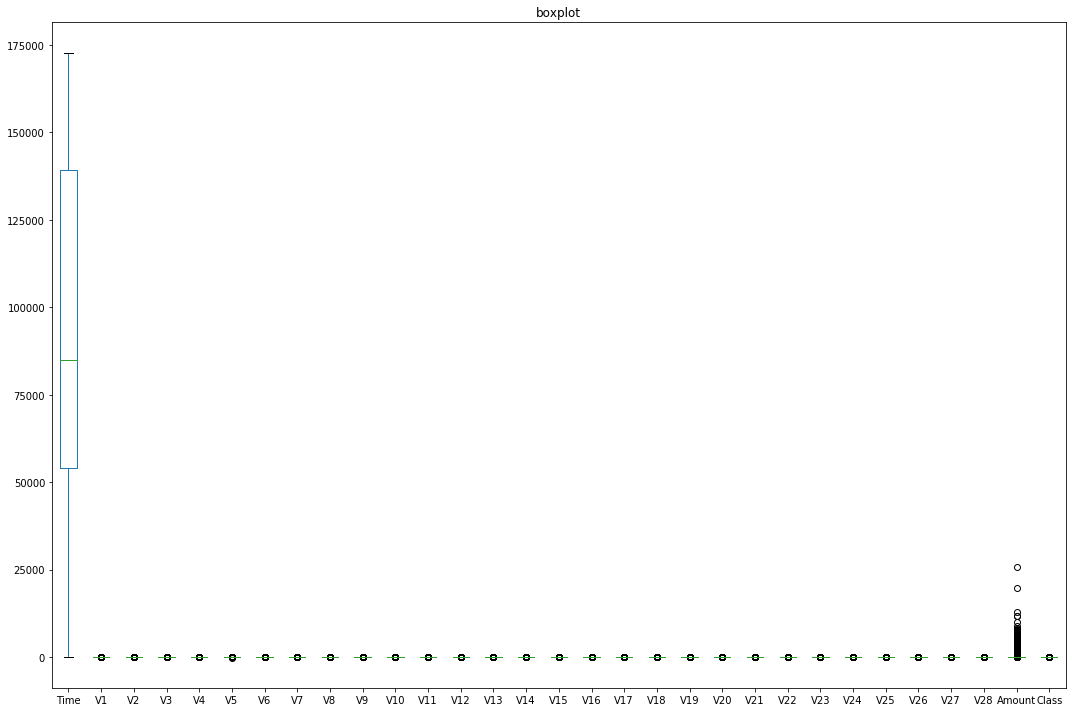

In [8]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["figure.autolayout"] = True
df_train.plot(kind='box', title='boxplot')

In order to have the meaningful plots we need to remove the 'time' and 'Amount' variable from the dataset.

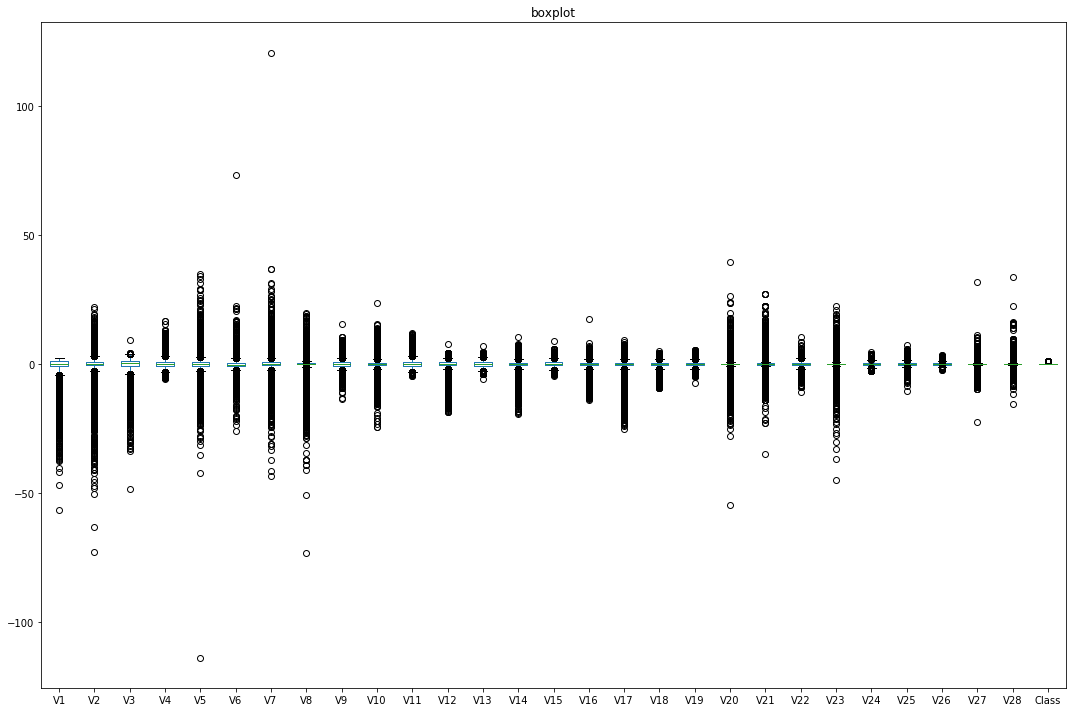

In [9]:
df_train.drop(["Amount", "Time"], axis = 1).plot(kind='box', title='boxplot')

We can see a lot of outliers. Let's can analyse the distribution of variables with respect to the dependent variable:

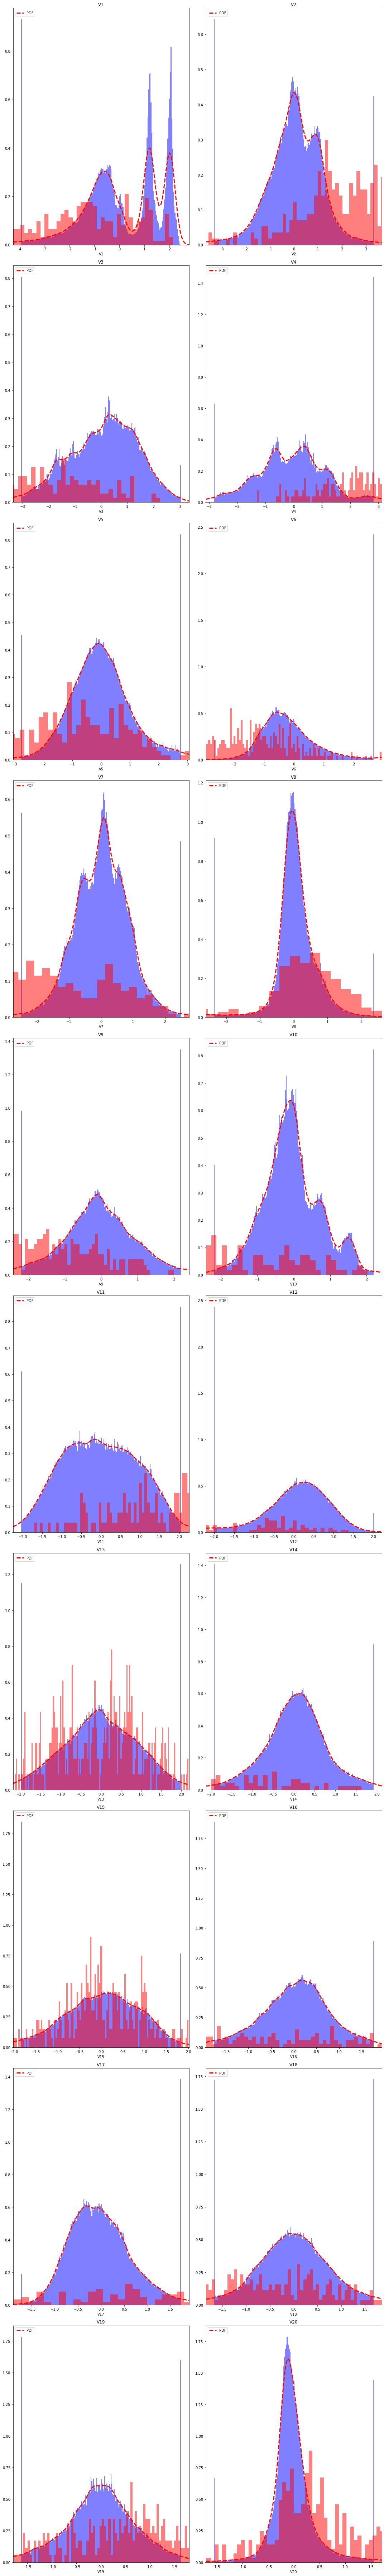

In [12]:
import numpy as np
from scipy import stats as st
from statistics import stdev
plt.rcParams["figure.figsize"] = (15,100)
for i in range(1, 21):
    
    plt.subplot(10, 2, i)
    x = df_train[df_train.columns[i]]
    mean = x.mean()
    sd = stdev(x)
    x = x.mask(x < (mean - 2 * sd), mean - 2 * sd)
    x = x.mask(x > (mean + 2 * sd), mean + 2 * sd)
    
    x_y = df_train[df_train.columns[i]]
    ind = df_train['Class'].values == 1
    x_y = x_y[ind]
    
    plt.hist(x, density=True, bins=200, color = "blue", cumulative = False, alpha=0.5)
    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 100)
    kde = st.gaussian_kde(df_train[df_train.columns[i]])
    plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF", linestyle='dashed', linewidth=3, color = "red")
    plt.hist(x_y, density=True, bins=200, color = "red", cumulative = False, alpha=0.5)
    plt.legend(loc="upper left")
    plt.xlabel(df_train.columns[i])
    plt.title(df_train.columns[i]);

It looks like some variables are highly dependent on the fraud which is a promising observation. We can easily see the difference of distributions of the whole dataset and the fruad subset for many variables.

### Correlations

Before we go next, let's take a look at the correlation matrices for three most popular coefficients (Pearson, Spearman, Kendall)

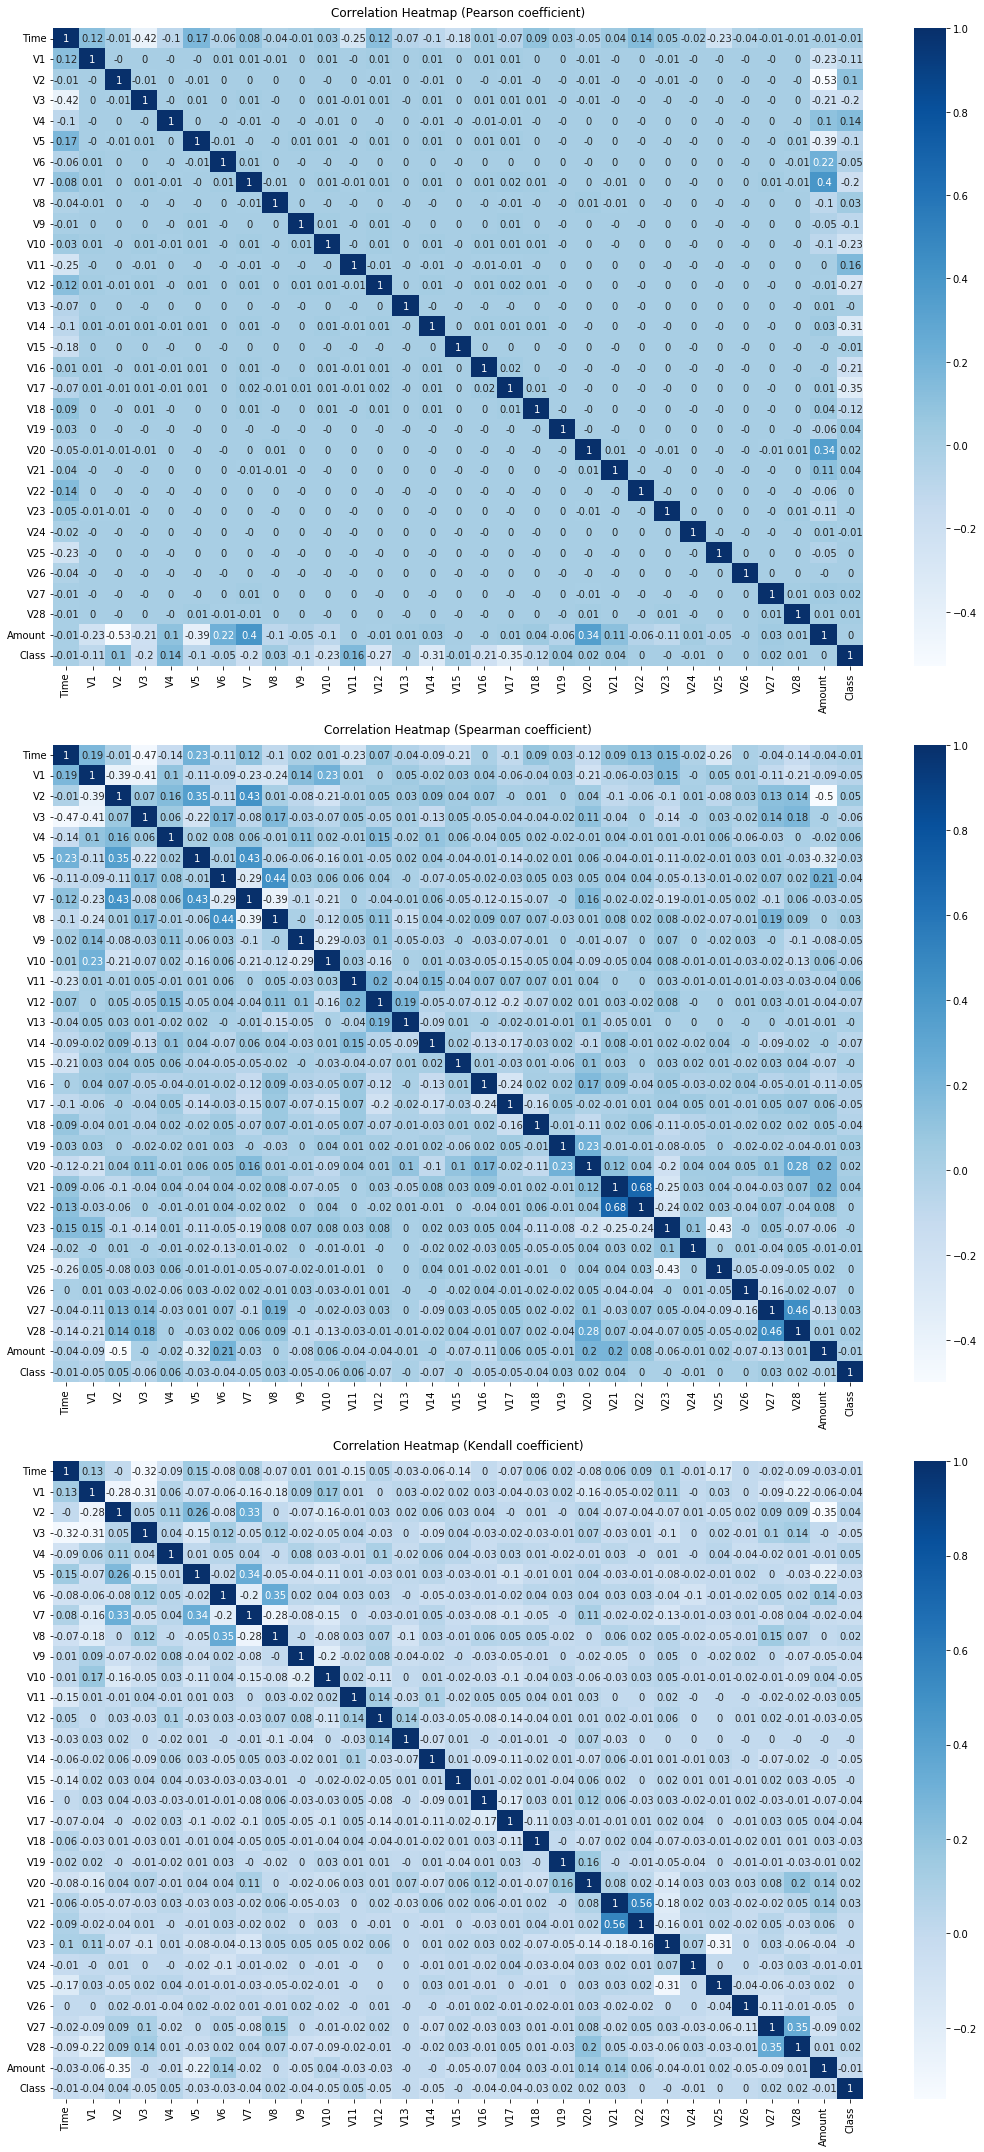

In [13]:
import seaborn as sns
pd.options.display.float_format = '{:.2%}'.format
plt.rcParams["figure.figsize"] = (15,30)

plt.subplot(3, 1, 1)
heatmap = sns.heatmap(df_train.corr().round(2), annot=True,  cmap='Blues')
heatmap.set_title('Correlation Heatmap (Pearson coefficient)', fontdict={'fontsize':12}, pad=12);

plt.subplot(3, 1, 2)
heatmap = sns.heatmap(df_train.corr(method = "spearman").round(2), annot=True,  cmap='Blues')
heatmap.set_title('Correlation Heatmap (Spearman coefficient)', fontdict={'fontsize':12}, pad=12);

plt.subplot(3, 1, 3)
heatmap = sns.heatmap(df_train.corr(method = "kendall").round(2), annot=True,  cmap='Blues')
heatmap.set_title('Correlation Heatmap (Kendall coefficient)', fontdict={'fontsize':12}, pad=12);

We can also take a look at the features correlated with the fraud indicator.

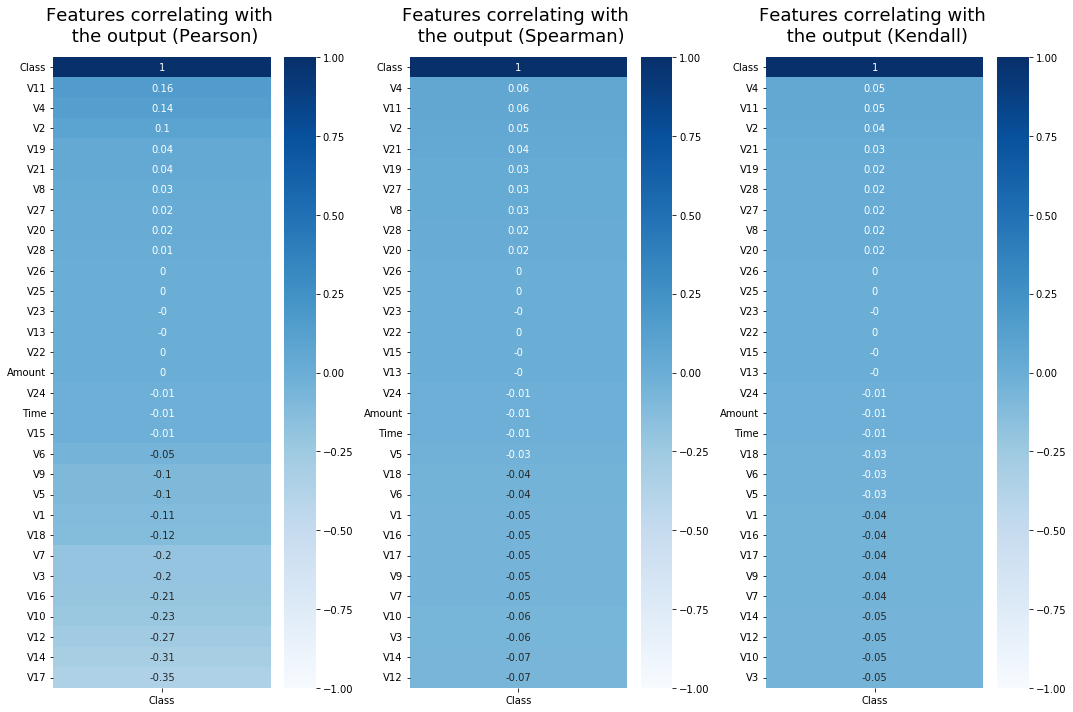

In [14]:
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(1, 3, 1)
heatmap = sns.heatmap(df_train.corr()[['Class']].round(2).sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Features correlating with \n the output (Pearson)', fontdict={'fontsize':18}, pad=16);

plt.subplot(1, 3, 2)
heatmap = sns.heatmap(df_train.corr(method = "spearman")[['Class']].round(2).sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Features correlating with \n the output (Spearman)', fontdict={'fontsize':18}, pad=16);

plt.subplot(1, 3, 3)
heatmap = sns.heatmap(df_train.corr(method = "kendall")[['Class']].round(2).sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Features correlating with \n the output (Kendall)', fontdict={'fontsize':18}, pad=16);

### Outliers detection

In [15]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df_train.drop(['Class'], axis = 1))
outlier = model.predict(df_train.drop(['Class'], axis = 1))
outlier_df = pd.DataFrame({'outlier': outlier})
outlier_df.outlier.value_counts()

 1    192244
-1     21361
Name: outlier, dtype: int64

In [16]:
from sklearn import metrics
metrics.confusion_matrix(df_train.Class.values, outlier_df.outlier.values)

array([[     0,      0,      0],
       [ 21007,      0, 192209],
       [   354,      0,     35]], dtype=int64)

We can see that the dependent variable is highly assossiated with the outliers. Therefore, we won't exclude the outliers as the carry significant information about the output.

In [17]:
# ind1 = outlier_df.outlier.values == 1
# ind2 = df_train.Class == 1

# df_train_1 = df_train[ind1 | ind2.values]
# df_train_1.shape

In [18]:
df_train_1 = df_train.copy()

### Standarisation

As mentioned, we will standardise the data.

In [19]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(df_train_1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
df_train_2 = std_scaler.transform(df_train_1)
df_train_2 = pd.DataFrame(df_train_2, index=df_train_1.index, columns=df_train_1.columns)

In [21]:
df_train_2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,...,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%,21360500.00%
mean,0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,-0.00%,-0.00%,0.00%,0.00%,0.00%,-0.00%,0.00%,-0.00%,-0.00%
std,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,...,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
min,-199.81%,-2877.16%,-4378.22%,-3169.36%,-401.26%,-8185.28%,-1959.11%,-3488.51%,-6177.56%,-1220.07%,...,-4751.98%,-1507.74%,-7158.31%,-469.03%,-1972.11%,-525.36%,-5534.84%,-4670.42%,-35.13%,-4.27%
25%,-85.68%,-47.01%,-36.23%,-58.37%,-59.86%,-49.82%,-57.40%,-44.42%,-17.73%,-58.40%,...,-31.24%,-74.70%,-26.08%,-58.60%,-60.92%,-67.74%,-17.29%,-15.96%,-32.92%,-4.27%
50%,-21.21%,0.91%,3.96%,11.88%,-1.65%,-3.73%,-20.43%,3.24%,1.71%,-4.60%,...,-4.08%,1.01%,-1.95%,6.73%,3.04%,-10.80%,0.40%,3.43%,-26.42%,-4.27%
75%,93.73%,67.12%,48.40%,67.48%,52.24%,44.06%,29.82%,45.77%,27.42%,54.33%,...,25.34%,72.75%,23.46%,72.62%,67.07%,49.83%,22.37%,23.69%,-4.37%,-4.27%
max,164.10%,125.16%,1328.16%,615.58%,1180.22%,2504.67%,5490.26%,9658.06%,1652.50%,1416.61%,...,3711.22%,1448.71%,3598.89%,758.19%,1440.04%,728.59%,7754.05%,10245.30%,10135.95%,2341.18%


### PCA

Also, as we can see highly correlated featues, we will apply PCA technique to reduce the number of features remaining around 95% of the variance.

In [22]:
from sklearn.decomposition import PCA

Let's take a look at the paris with highest correlations:

In [23]:
pairs_to_drop = set()
cols = df_train_2.columns
for i in range(0, df_train_2.shape[1]):
    for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
au_corr = df_train_2.corr().abs().unstack()
au_corr = au_corr.drop(labels=pairs_to_drop).sort_values(ascending=False)
au_corr

V2    Amount   52.99%
Time  V3       41.82%
V7    Amount   39.94%
V5    Amount   38.71%
V17   Class    35.03%
                ...  
V5    V26       0.00%
V18   V21       0.00%
V24   V25       0.00%
V17   V25       0.00%
V21   V24       0.00%
Length: 465, dtype: float64

In [24]:
pca = PCA()
pca.fit(df_train_2.drop(['Class'], axis = 1))
print(np.cumsum(pca.explained_variance_ratio_).round(4))

[0.0654 0.1213 0.1578 0.1921 0.2263 0.2601 0.2937 0.3273 0.3608 0.3942
 0.4276 0.461  0.4943 0.5276 0.5609 0.5942 0.6274 0.6605 0.6937 0.7267
 0.7598 0.7927 0.8256 0.8585 0.8913 0.9238 0.9562 0.9882 0.9986 1.    ]


In [27]:
pca = PCA(27)
pca.fit(df_train_2.drop(['Class'], axis = 1))
sum(pca.explained_variance_ratio_).round(4)

0.9562

In [28]:
df_train_3 = pca.transform(df_train_2.drop(['Class'], axis = 1))
df_train_3 = pd.DataFrame(df_train_3)

In [29]:
df_train_3.corr()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,100.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,0.00%,...,0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%,0.00%,0.00%
1,0.00%,100.00%,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,...,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%
2,0.00%,-0.00%,100.00%,-0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.00%,0.00%,...,-0.00%,-0.00%,0.00%,0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,-0.00%
3,-0.00%,0.00%,-0.00%,100.00%,-0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.00%,...,0.00%,-0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%
4,-0.00%,0.00%,-0.00%,-0.00%,100.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%
5,-0.00%,-0.00%,0.00%,-0.00%,0.00%,100.00%,-0.00%,0.00%,0.00%,-0.00%,...,0.00%,-0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%
6,0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,100.00%,0.00%,-0.00%,0.00%,...,0.00%,-0.00%,0.00%,0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%,0.00%
7,-0.00%,-0.00%,0.00%,-0.00%,-0.00%,0.00%,0.00%,100.00%,-0.00%,0.00%,...,0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%,-0.00%,0.00%,0.00%,-0.00%
8,-0.00%,0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.00%,-0.00%,100.00%,-0.00%,...,-0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%,0.00%
9,0.00%,-0.00%,0.00%,-0.00%,0.00%,-0.00%,0.00%,0.00%,-0.00%,100.00%,...,-0.00%,0.00%,-0.00%,0.00%,-0.00%,0.00%,0.00%,0.00%,-0.00%,-0.00%


## Modelling part

Now, we can try to model our fraud output.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [31]:
print(df_train_3.shape)
print(len(df_train_1['Class']))

(213605, 27)
213605


In [32]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_train_3, df_train_1['Class'])

In [33]:
df1 = pd.DataFrame({'a': y_train})
df1.a.value_counts()

0    159914
1       289
Name: a, dtype: int64

In [34]:
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))

(160203, 27)
160203
(53402, 27)
53402


The data has a lot of observations, hence I had to proceed with the subsample of the dataset.

In [35]:
ind_1 = np.random.choice([True, False], X_train.shape[0], p = [0.3, 0.7])
ind_2 = np.random.choice([True, False], X_test.shape[0], p = [0.3, 0.7])

In [36]:
X_trainset = X_train[ind_1]
y_trainset = y_train[ind_1]
X_testset = X_test[ind_2]
y_testset = y_test[ind_2]

In [37]:
df1 = pd.DataFrame({'a': y_trainset})
df1.a.value_counts()

0    47932
1       86
Name: a, dtype: int64

In [38]:
df1 = pd.DataFrame({'a': y_testset})
df1.a.value_counts()

0    15951
1       29
Name: a, dtype: int64

In [39]:
drugTree = DecisionTreeClassifier()
LR = LogisticRegression()
neigh = KNeighborsClassifier()
svc = svm.SVC(probability = True)
lda = LinearDiscriminantAnalysis()
mlp = MLPClassifier()
gnb = GaussianNB()

In [40]:
drugTree.fit(X_trainset, y_trainset) 
LR.fit(X_trainset, y_trainset)
neigh.fit(X_trainset, y_trainset)
svc.fit(X_trainset, y_trainset)
lda.fit(X_trainset,y_trainset)
mlp.fit(X_trainset, y_trainset)
gnb.fit(X_trainset, y_trainset)

GaussianNB(priors=None, var_smoothing=1e-09)

In [41]:
from sklearn.metrics import roc_auc_score
width = 50
models = [drugTree, LR, neigh, svc, lda, mlp, gnb]
descriptions = ['DecisionTreeClassifier', 'Logistic Regression', "K-neighbours", 'Support-vector machine', 
                'LinearDiscriminantAnalysis', "MLPClassifier", "GaussianNB"]

# models = [drugTree, mlp, gnb]
# descriptions = ['DecisionTreeClassifier', 
#               "MLPClassifier", "GaussianNB"]

for model, description in zip(models, descriptions):
    
    y_train_pred = model.predict(X_trainset)
    y_train_pred_probs = model.predict_proba(X_trainset)
    
    y_test_pred = model.predict(X_testset)
    y_test_pred_probs = model.predict_proba(X_testset)
    
    auc_train = roc_auc_score(y_trainset, y_train_pred_probs[:, 1])
    auc_test = roc_auc_score(y_testset, y_test_pred_probs[:, 1])
    
    cm=metrics.confusion_matrix(y_trainset,y_train_pred)
    df_cm = pd.DataFrame(cm)
    
    cm_test = metrics.confusion_matrix(y_testset, y_test_pred)
    df_cm_test = pd.DataFrame(cm_test)
    
    print("\n")
    
    print("--------------------------------------------------------")
    print("Method: {desc}".format(desc = description).center(width))
    print("--------------------------------------------------------")
    print("Confusion matrix (Training dataset):")
    print(df_cm)
    print("------------------------------------")
    print("Confusion matrix (Test dataset):")
    print(df_cm_test)
    print("\n")
    print("Training set (test set) ")
    print("Accuracy: {trainacc:>24.2%} ({asd:.2%})".format(trainacc = metrics.accuracy_score(y_train_pred, y_trainset), asd = metrics.accuracy_score(y_test_pred, y_testset)))
    print("AUC:      {trainacc:>24.2%} ({asd:.2%})".format(trainacc = auc_train, asd = auc_test))

    print("Precision (micro): {trainacc:>15.2%} ({asd:.2%})".format(trainacc = metrics.precision_score(y_train_pred, y_trainset, average = "micro"), asd = metrics.precision_score(y_test_pred, y_testset, average = "micro")))
    print("Precision (macro): {trainacc:>15.2%} ({asd:.2%})".format(trainacc = metrics.precision_score(y_train_pred, y_trainset, average = "macro"), asd = metrics.precision_score(y_test_pred, y_testset, average = "macro")))

    print("Recall (micro): {trainacc:>18.2%} ({asd:.2%})".format(trainacc = metrics.precision_score(y_train_pred, y_trainset, average = "micro"), asd = metrics.precision_score(y_test_pred, y_testset, average = "micro")))
    print("Recall (macro): {trainacc:>18.2%} ({asd:.2%})".format(trainacc = metrics.precision_score(y_train_pred, y_trainset, average = "macro"), asd = metrics.precision_score(y_test_pred, y_testset, average = "macro")))

    print("F1 (micro): {trainacc:>22.2%} ({asd:.2%})".format(trainacc = metrics.f1_score(y_train_pred, y_trainset, average = "micro"), asd = metrics.f1_score(y_test_pred, y_testset, average = "micro")))
    print("F1 (macro): {trainacc:>22.2%} ({asd:.2%})".format(trainacc = metrics.f1_score(y_train_pred, y_trainset, average = "macro"), asd = metrics.f1_score(y_test_pred, y_testset, average = "macro")))





--------------------------------------------------------
          Method: DecisionTreeClassifier          
--------------------------------------------------------
Confusion matrix (Training dataset):
       0   1
0  47932   0
1      0  86
------------------------------------
Confusion matrix (Test dataset):
       0   1
0  15947   4
1      8  21


Training set (test set) 
Accuracy:                  100.00% (99.92%)
AUC:                       100.00% (86.19%)
Precision (micro):         100.00% (99.92%)
Precision (macro):         100.00% (86.19%)
Recall (micro):            100.00% (99.92%)
Recall (macro):            100.00% (86.19%)
F1 (micro):                100.00% (99.92%)
F1 (macro):                100.00% (88.87%)


--------------------------------------------------------
           Method: Logistic Regression            
--------------------------------------------------------
Confusion matrix (Training dataset):
       0   1
0  47924   8
1     27  59
--------------------------

# Original testset 

Now we should select the best model. According to the data, nerual network seems to be the best choice. Let's check its performance on df_train set that we extracted from the original dataset before applying any transformation techniques.

We have to apply all transformation technique that we performed on train datasets.

In [42]:
df_train_2 = std_scaler.transform(df_test)
df_train_2 = pd.DataFrame(df_train_2, index=df_test.index, columns=df_test.columns)

In [43]:
df_train_3 = pca.transform(df_train_2.drop(['Class'], axis = 1))
df_train_3 = pd.DataFrame(df_train_3)

In [44]:
df_train_2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,...,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%,7120200.00%
mean,-0.49%,-0.24%,0.20%,0.80%,0.01%,0.77%,0.90%,0.01%,-0.60%,0.53%,...,-0.26%,0.57%,-0.44%,0.21%,-0.84%,-0.91%,0.50%,0.19%,-0.62%,-0.88%
std,100.05%,99.62%,97.69%,97.77%,99.87%,97.28%,99.12%,96.26%,103.04%,99.15%,...,100.84%,100.35%,99.04%,100.62%,99.36%,99.68%,95.95%,99.65%,96.03%,89.14%
min,-199.81%,-2042.46%,-3640.57%,-2039.81%,-381.39%,-2909.16%,-1206.15%,-2498.60%,-4298.32%,-859.35%,...,-3122.86%,-1310.00%,-4347.87%,-466.68%,-1356.51%,-539.91%,-2427.01%,-2546.23%,-35.13%,-4.27%
25%,-85.58%,-46.96%,-35.33%,-57.77%,-60.10%,-48.85%,-57.10%,-44.19%,-17.81%,-57.87%,...,-31.18%,-74.54%,-25.56%,-58.57%,-61.12%,-68.75%,-17.14%,-16.04%,-32.92%,-4.27%
50%,-21.86%,0.70%,4.09%,12.31%,-0.51%,-3.69%,-19.92%,3.11%,1.80%,-4.34%,...,-4.07%,1.31%,-1.71%,7.14%,2.71%,-11.76%,0.60%,3.50%,-26.43%,-4.27%
75%,93.30%,66.72%,48.57%,67.83%,53.27%,44.78%,30.90%,45.41%,27.66%,54.45%,...,25.45%,74.05%,23.54%,73.14%,66.68%,49.32%,22.72%,23.92%,-5.05%,-4.27%
max,164.10%,125.00%,1006.37%,269.22%,1191.50%,1753.50%,1791.59%,3528.34%,1687.89%,940.07%,...,3711.22%,1141.03%,3527.82%,663.91%,1162.55%,717.38%,2980.90%,4773.29%,7451.30%,2341.18%


In [45]:
import os
from sklearn.metrics import roc_auc_score

models = [drugTree, LR, neigh, svc, lda, mlp, gnb]
descriptions = ['DecisionTreeClassifier', 'Logistic Regression', "K-neighbours", 'Support-vector machine', 'LinearDiscriminantAnalysis',
              "MLPClassifier", "GaussianNB"]

y_testset = df_test['Class'].values

for model, description in zip(models, descriptions):
    
    y_test_pred = model.predict(df_train_3)
    y_test_pred_probs = model.predict_proba(df_train_3)

    auc_test = roc_auc_score(y_testset, y_test_pred_probs[:, 1])
    
    cm_test = metrics.confusion_matrix(y_testset, y_test_pred)
    df_cm_test = pd.DataFrame(cm_test)
    
    print("\n")
    
    print("--------------------------------------------------------")
    print("Method: {desc}".format(desc = description).center(width))
    print("--------------------------------------------------------")
    print("\n")
    print("Confusion matrix (Test dataset):")
    print(df_cm_test)
    print("\n")
    print("Training set (test set) ")
    print("Accuracy: {asd:>24.2%}".format(asd = metrics.accuracy_score(y_test_pred, y_testset)))
    print("AUC:      {asd:>24.2%}".format(asd = auc_test))

    print("Precision (micro): {asd:>15.2%}".format(asd = metrics.precision_score(y_test_pred, y_testset, average = "micro")))
    print("Precision (macro): {asd:>15.2%}".format(asd = metrics.precision_score(y_test_pred, y_testset, average = "macro")))

    print("Recall (micro): {asd:>18.2%}".format(asd = metrics.precision_score(y_test_pred, y_testset, average = "micro")))
    print("Recall (macro): {asd:>18.2%}".format(asd = metrics.precision_score(y_test_pred, y_testset, average = "macro")))

    print("F1 (micro): {asd:>22.2%}".format(asd = metrics.f1_score(y_test_pred, y_testset, average = "micro")))
    print("F1 (macro): {asd:>22.2%}".format(asd = metrics.f1_score(y_test_pred, y_testset, average = "macro")))





--------------------------------------------------------
          Method: DecisionTreeClassifier          
--------------------------------------------------------


Confusion matrix (Test dataset):
       0   1
0  71075  24
1     30  73


Training set (test set) 
Accuracy:                   99.92%
AUC:                        85.42%
Precision (micro):          99.92%
Precision (macro):          85.42%
Recall (micro):             99.92%
Recall (macro):             85.42%
F1 (micro):                 99.92%
F1 (macro):                 86.48%


--------------------------------------------------------
           Method: Logistic Regression            
--------------------------------------------------------


Confusion matrix (Test dataset):
       0   1
0  71089  10
1     42  61


Training set (test set) 
Accuracy:                   99.93%
AUC:                        95.31%
Precision (micro):          99.93%
Precision (macro):          79.60%
Recall (micro):             99.93%
Recall (m